# Character-Level MLP Model

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/inefficient-networks/blob/master/docs/notebooks/tensorflow/05-tensorflow-cnn.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/inefficient-networks?style=social)](https://github.com/particle1331/inefficient-networks)

---

## Introduction

This notebook is based on [this tutorial](https://www.youtube.com/watch?v=TCH_1BHY58I) by [Andrej Karpathy](https://karpathy.ai/) on language modeling. In this tutorial, we implement a multilayer perceptron (MLP) character-level language model. This also introduces many basics of machine learning (e.g. model training, learning rate tuning, hyperparameters, evaluation, train/dev/test splits, under/overfitting, etc.).


**Readings**

* 

Exercises:
- E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2
- E02: I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?
- E03: Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?



Since context is length 1, the generated names are pretty bad. We saw that using  If we use `k` characters as context, $27^k$ rows. Too few data to train this. 

We move to a new model MLP to predict next character. Bengio 2013 paper. 



In [1]:
import math
import warnings
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib_inline import backend_inline

DATASET_DIR = Path("./data").absolute()
RANDOM_SEED = 42
DEBUG = True
if DEBUG:
    TRAIN_RATIO = 0.3
    img_format = 'png'
else:
    TRAIN_RATIO = 1.0
    img_format = 'svg'

warnings.simplefilter(action="ignore")
backend_inline.set_matplotlib_formats(img_format)

In [2]:
names = open(DATASET_DIR / 'names.txt', 'r').read().splitlines()
names = names[:int(TRAIN_RATIO * len(names))]

print(len(names))
names[:10]

9609


['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
from itertools import product
import functools

chars = ['.'] + sorted(list(set(''.join(names))))
itos = dict(enumerate(chars))
stoi = {c: i for i, c in itos.items()}

# @functools.lru_cache()
# def itox(context_size):
#     return dict(enumerate(map(lambda z: ''.join(z), product(stoi.keys(), repeat=context_size))))

# @functools.lru_cache()
# def xtoi(context_size):
#     return {x: i for i, x in itox(context_size).items()}

In [4]:
def build_dataset(context_size=1):
    """Creating subsequences -> next character target."""
    xs = []
    ys = []
    for i, name in enumerate(names):
        context = ['.'] * context_size
        for c in name + '.':
            xs.append([stoi[c] for c in context])
            ys.append(stoi[c])
            context = context[1:] + [c]
    return xs, ys

In [5]:
xs, ys =  build_dataset(3)

In [6]:
import pandas as pd

context_size = 3
xs, ys = build_dataset(context_size=context_size)

df = pd.DataFrame({'xs': xs, 'ys': ys})
df['seq'] = df['xs'].apply(lambda x: ''.join(itos[c] for c in x))
df['target'] = df['ys'].map(itos)
df.head(12)

,xs,ys,seq,target
0,"[0, 0, 0]",5,...,e
1,"[0, 0, 5]",13,..e,m
2,"[0, 5, 13]",13,.em,m
3,"[5, 13, 13]",1,emm,a
4,"[13, 13, 1]",0,mma,.
5,"[0, 0, 0]",15,...,o
6,"[0, 0, 15]",12,..o,l
7,"[0, 15, 12]",9,.ol,i
8,"[15, 12, 9]",22,oli,v
9,"[12, 9, 22]",9,liv,i


Embed 27 letters to 2d

In [7]:
import torch

embedding_size = 2 
C = torch.randn(27, embedding_size)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
C[xs].shape

torch.Size([68554, 3, 2])

In [8]:
print(xs[15])
C[xs[15]]

tensor([ 1, 22,  1])


tensor([[-1.0153, -1.4639],
        [-0.4755, -0.2204],
        [-1.0153, -1.4639]])

In [9]:
C[1], C[22]

(tensor([-1.0153, -1.4639]), tensor([-0.4755, -0.2204]))

In [10]:
embedding = C[xs].view(-1, context_size * embedding_size)
embedding.shape

torch.Size([68554, 6])

Reshaping this -> introduces order into structure of network. 

MLP network:

In [11]:
import torch.nn.functional as F

class MLP:
    def __init__(self, width, embedding_size, input_shape, seed=2147483647):
        self.width = width
        self.ctx_size = input_shape[1]
        self.emb_size = embedding_size
        self._init_weights(seed)
        
    def _init_weights(self, seed):
        self.g = torch.Generator().manual_seed(seed)
        self.C0 = torch.randn(27, self.emb_size, generator=self.g)
        self.W1 = torch.randn((self.ctx_size * self.emb_size, self.width), generator=self.g)
        self.b1 = torch.randn(self.width, generator=self.g)
        self.W2 = torch.randn((self.width, 27), generator=self.g)
        self.b2 = torch.randn(27, generator=self.g)
        self.parameters = [self.C0, self.W1, self.b1, self.W2, self.b2]
        for p in self.parameters:
            p.requires_grad = True

    def __call__(self, xs: list[int]):
        emb = self.C0[xs].view(-1, self.ctx_size * self.emb_size)
        h = torch.tanh(emb @ self.W1 + self.b1)
        logits = h @ self.W2 + self.b2
        return logits

    def zero_grad(self):
        for p in self.parameters:
           p.grad = None

    def optim_step(self, lr):
        for p in self.parameters:
           p.data -= lr * p.grad


In [12]:
model = MLP(100, 2, xs.shape)

In [13]:
F.cross_entropy(model(xs), ys)

tensor(19.4219, grad_fn=<NllLossBackward0>)

In [14]:
def train_model(model, xs, ys, num_steps=100, lr=0.1):
    losses = []
    for k in range(num_steps):
        logits = model(xs)
        loss = F.cross_entropy(logits, target=ys)

        model.zero_grad()
        loss.backward()
        model.optim_step(lr=lr)

        # logging
        losses.append(loss.item())
        if k % 10 == 9:
            print(f"[{k+1:>03d}/{num_steps}]   loss={loss:.4f}")

    return losses


model = MLP(100, 2, xs.shape)
hist = train_model(model, xs, ys, num_steps=100, lr=0.1)

[010/100]   loss=10.8190
[020/100]   loss=8.2506
[030/100]   loss=6.6534
[040/100]   loss=5.6208
[050/100]   loss=4.8751
[060/100]   loss=4.3306
[070/100]   loss=3.9553
[080/100]   loss=3.6986
[090/100]   loss=3.5148
[100/100]   loss=3.3761


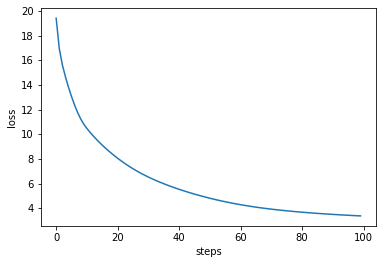

In [15]:
plt.plot(hist)
plt.ylabel('loss')
plt.xlabel('steps');

Minibatches:

In [16]:
def train_model(model, xs, ys, batch_size, num_steps, lr=0.1, verbose=True, seed=42):
    losses = []
    g = torch.Generator().manual_seed(seed)
    for k in range(num_steps):
        B = torch.randint(0, xs.shape[0], (batch_size,), generator=g)        
        logits = model(xs[B])
        loss = F.cross_entropy(logits, target=ys[B])

        model.zero_grad()
        loss.backward()
        model.optim_step(lr=lr)

        # logging
        losses.append(loss.item())
        if verbose and (k % int(0.1 * num_steps) == 0):
            print(f"[{k:>0{int(math.log10(num_steps))}d}/{num_steps}]   loss: {loss:.4f}")

    return losses


model = MLP(100, 2, xs.shape)
hist = train_model(model, xs, ys, batch_size=32, num_steps=10000, lr=0.1)

[0000/10000]   loss: 17.0046
[1000/10000]   loss: 2.6042
[2000/10000]   loss: 2.0561
[3000/10000]   loss: 2.3296
[4000/10000]   loss: 2.6371
[5000/10000]   loss: 2.2608
[6000/10000]   loss: 2.2241
[7000/10000]   loss: 2.0338
[8000/10000]   loss: 2.2408
[9000/10000]   loss: 2.4222


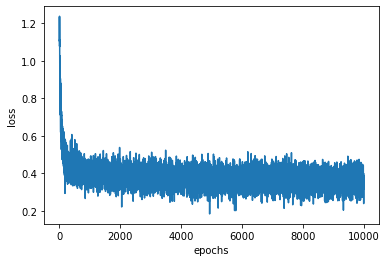

In [17]:
plt.plot(torch.tensor(hist).log10())
plt.xlabel("epochs")
plt.ylabel("loss");

Finding good LR: 
(1) decrease number of steps, 
(2) run 100 lrs.
this is because we are looking for lr0 and we can perform lr scheduling, so we dont need high number of steps. Idea here is to start with small base loss, keep increasing loss until it explodes. So we start with min. Then work backwards again, to get smaller losses. 

In [28]:
seed = 42
num_steps = 300
losses = []
lre = torch.linspace(-3, 0, num_steps) 
lrs = 10 ** lre
batch_size = 32

model = MLP(100, 2, xs.shape)
g = torch.Generator().manual_seed(seed)
for k in range(num_steps):
    B = torch.randint(0, xs.shape[0], (batch_size,), generator=g)        
    logits = model(xs[B])
    loss = F.cross_entropy(logits, target=ys[B])

    model.zero_grad()
    loss.backward()
    model.optim_step(lr=lrs[k])

    # logging
    losses.append(loss.item())

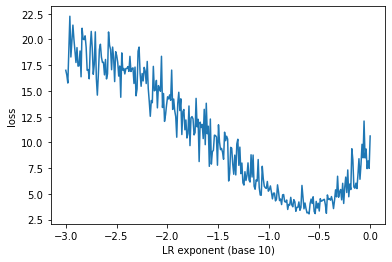

In [29]:
plt.plot(lre, torch.tensor(losses).numpy());
plt.ylabel('loss')
plt.xlabel('LR exponent (base 10)');

In [22]:
lre0 = min(zip(losses, lre))[1]
lr0 = 10 ** lre0

In [23]:
model = MLP(100, 2, xs.shape)
hist = train_model(model, xs, ys, batch_size=32, num_steps=100000, lr=lr0)

[00000/100000]   loss: 17.3533
[10000/100000]   loss: 3.1688
[20000/100000]   loss: 2.2033
[30000/100000]   loss: 2.7740
[40000/100000]   loss: 2.4672
[50000/100000]   loss: 2.2319
[60000/100000]   loss: 2.3484
[70000/100000]   loss: 2.4954
[80000/100000]   loss: 2.1906
[90000/100000]   loss: 2.0439


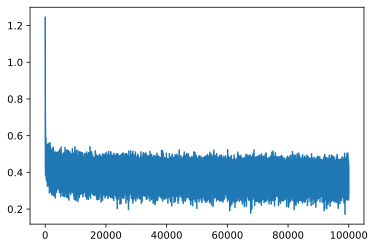

In [24]:
plt.plot(torch.tensor(hist).log10().numpy());

In [25]:
F.cross_entropy(model(xs), ys) # train loss

tensor(2.3169, grad_fn=<NllLossBackward0>)

In [26]:
from sklearn.model_selection import StratifiedKFold

def create_folds(xs, ys, seed=42):
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    folds = torch.zeros(xs.shape[0])
    for fold, (trn_, val_) in enumerate(kf.split(xs, ys)):
        folds[val_] = fold

    xs_trn, ys_trn = xs[folds >  1], ys[folds >  1]
    xs_dev, ys_dev = xs[folds == 1], ys[folds == 1]
    xs_tst, ys_tst = xs[folds == 0], ys[folds == 0]

    return xs_trn, ys_trn, xs_dev, ys_dev, xs_tst, ys_tst


def cross_entropy_loss(model, xs, ys):
    return F.cross_entropy(model(xs), ys)


def train_model(
        model, 
        xs, ys, 
        xs_dev, ys_dev, 
        batch_size,
        num_steps,
        loss_fn=cross_entropy_loss,
        lr=0.1,
        eval_fn=None,
        verbose=True,
        seed=42
    ):
    
    if eval_fn is None:
        eval_fn = loss_fn

    losses_trn = {}
    losses_dev = {}

    g = torch.Generator().manual_seed(seed)
    for k in range(num_steps):
        lr_step = lr if k < 0.5 * num_steps else 0.1 * lr

        B = torch.randint(0, xs.shape[0], (batch_size,), generator=g)        
        logits = model(xs[B])
        loss = F.cross_entropy(logits, target=ys[B])

        model.zero_grad()
        loss.backward()
        model.optim_step(lr=lr_step)

        # logging
        losses_trn[k] = loss.item()
        if k % int(0.1 * num_steps) == 0:
            loss_dev = eval_fn(model, xs_dev, ys_dev)
            losses_dev[k] = loss_dev.item()
            if verbose:
                print(f"[{k:>0{int(math.log10(num_steps))}d}/{num_steps}]    loss={loss:.4f}    dev_loss={loss_dev:.4f}")
    
    return {"loss_trn": losses_trn, "loss_dev": losses_dev}

[00000/100000]    loss=17.0642    dev_loss=16.5304
[10000/100000]    loss=2.7029    dev_loss=2.5200
[20000/100000]    loss=2.5373    dev_loss=2.5122
[30000/100000]    loss=2.5646    dev_loss=2.4276
[40000/100000]    loss=2.5863    dev_loss=2.3618
[50000/100000]    loss=2.2143    dev_loss=2.3439
[60000/100000]    loss=2.6086    dev_loss=2.2716
[70000/100000]    loss=1.8971    dev_loss=2.2697
[80000/100000]    loss=2.5156    dev_loss=2.2650
[90000/100000]    loss=2.3392    dev_loss=2.2642


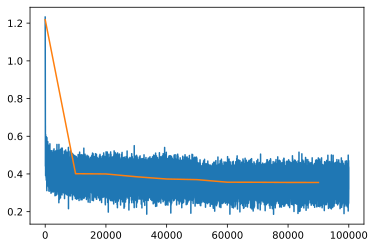

In [27]:
xs_trn, ys_trn, xs_dev, ys_dev, xs_tst, ys_tst = create_folds(xs, ys)
model = MLP(100, 2, xs.shape)
hist = train_model(model, xs_trn, ys_trn, xs_dev, ys_dev, batch_size=32, num_steps=100000, lr=lr0)

plt.plot(hist['loss_trn'].keys(), torch.tensor(list(hist['loss_trn'].values())).log10());
plt.plot(hist['loss_dev'].keys(), torch.tensor(list(hist['loss_dev'].values())).log10());

[00000/200000]    loss=53.4670    dev_loss=42.2525
[20000/200000]    loss=3.1223    dev_loss=3.4113
[40000/200000]    loss=2.9282    dev_loss=2.7999
[60000/200000]    loss=3.0958    dev_loss=2.5268
[80000/200000]    loss=2.6429    dev_loss=2.5086
[100000/200000]    loss=2.2007    dev_loss=2.5039
[120000/200000]    loss=2.2044    dev_loss=2.2896
[140000/200000]    loss=2.0641    dev_loss=2.2860
[160000/200000]    loss=2.1642    dev_loss=2.2774
[180000/200000]    loss=2.4576    dev_loss=2.2755


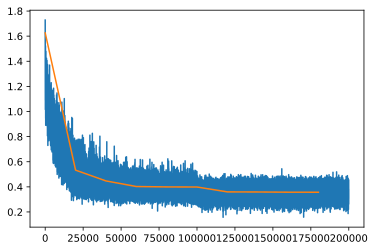

In [28]:
xs_trn, ys_trn, xs_dev, ys_dev, xs_tst, ys_tst = create_folds(xs, ys)
model = MLP(1000, 2, xs.shape)
hist = train_model(model, xs_trn, ys_trn, xs_dev, ys_dev, batch_size=32, num_steps=200000, lr=lr0)

plt.plot(hist['loss_trn'].keys(), torch.tensor(list(hist['loss_trn'].values())).log10());
plt.plot(hist['loss_dev'].keys(), torch.tensor(list(hist['loss_dev'].values())).log10());

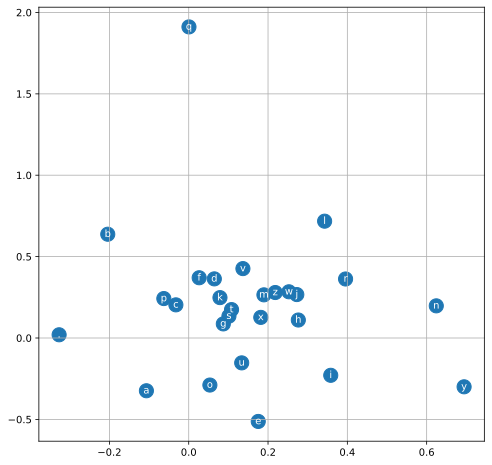

In [29]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(model.C0[:,0].data, model.C0[:,1].data, s=200)
for i in range(model.C0.shape[0]):
    plt.text(model.C0[i,0].item(), model.C0[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')


[00000/200000]    loss=26.8425    dev_loss=23.8698
[20000/200000]    loss=2.4947    dev_loss=2.5202
[40000/200000]    loss=2.6765    dev_loss=2.3472
[60000/200000]    loss=2.8994    dev_loss=2.3135
[80000/200000]    loss=2.6203    dev_loss=2.3088
[100000/200000]    loss=2.1347    dev_loss=2.2869
[120000/200000]    loss=2.0720    dev_loss=2.1725
[140000/200000]    loss=2.0518    dev_loss=2.1679
[160000/200000]    loss=1.9452    dev_loss=2.1674
[180000/200000]    loss=2.2708    dev_loss=2.1653


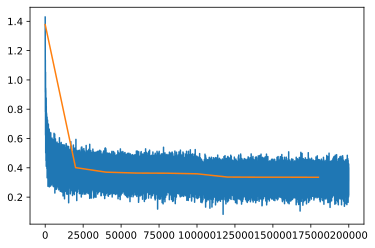

In [33]:
xs_trn, ys_trn, xs_dev, ys_dev, xs_tst, ys_tst = create_folds(xs, ys)
model = MLP(200, 10, xs.shape)
hist = train_model(model, xs_trn, ys_trn, xs_dev, ys_dev, batch_size=32, num_steps=200000, lr=0.5*lr0)

plt.plot(hist['loss_trn'].keys(), torch.tensor(list(hist['loss_trn'].values())).log10());
plt.plot(hist['loss_dev'].keys(), torch.tensor(list(hist['loss_dev'].values())).log10());

In [68]:
def generate_names(model, context_size, sample_size, seed=2147483647):
    """Generate names from a Markov process with cond probability table P."""

    g = torch.Generator().manual_seed(seed)
    names = []
    for _ in range(sample_size):
        out = []
        context = [0] * context_size
        while True:
            p = model(torch.tensor(context)).exp()
            j = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
            if j == 0:
                break
            context = context[1:] + [j]
            out.append(itos[j])
        names.append(''.join(out))
    return names

In [70]:
F.cross_entropy(model(xs_tst), ys_tst)

tensor(2.1806, grad_fn=<NllLossBackward0>)

In [69]:
def name_loss(name, context_size, model):
    nll = 0.0
    context = [0] * context_size
    for c in name + '.':
        p = F.softmax(model(torch.tensor(context))).reshape(-1)[stoi[c]]
        nll += -math.log(p)
        context = context[1:] + [stoi[c]]
    return nll / (len(name) + 1)


sample = generate_names(model, 3, sample_size=12)
name_losses = {n: name_loss(n, 3, model) for n in sample}
for n in sorted(sample, key=lambda n: name_losses[n]):
    print(f"{n:<22} {name_losses[n]:.3f}")


melynn                 1.390
avra                   1.776
klani                  1.829
makayshe               1.839
shaegenjiana           2.003
ilee                   2.008
min                    2.107
paisel                 2.201
hoffeandishey          2.488
zelo                   2.502
rii                    2.840
gaet                   2.863
